Pre-lab

In [1]:
%env PYTHONHASHSEED 3
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark

env: PYTHONHASHSEED=3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 25.2 MB/s eta 0:00:00


In [2]:
from math import sqrt
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import *
spark = SparkSession.builder.master("local[*]").appName('SparkExample').config(
    "spark.executor.memory", "1g").config("spark.ui.port", "4050"
        ).getOrCreate()
sc = spark.sparkContext

Helper function

In [3]:
import re

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

def remove_nonletters(word):
  return re.sub(r'[^a-zA-Z]', '', word)

Wordcount example

In [4]:
#word count and working with files. 
import urllib.request
url = 'https://www.gutenberg.org/files/16/16-0.txt'
filename = 'peterpan.txt'
urllib.request.urlretrieve(url, filename)

# load the file into a distributed dataset of lines
file = sc.textFile("peterpan.txt")
# split each line into (word, 1) tuples - removing non letters
def split_remove_nonletters(line):
  result = []
  for word in line.split(" "):
    removed_token = remove_nonletters(word.lower())
    if removed_token != '':
      result.append((removed_token, 1))
  return result
words = file.flatMap(split_remove_nonletters)
# reduce by key (the word) the counts and sort descending
counts = words.reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], False) 
dbg(counts.collect())

[('the', 2526), ('and', 1479), ('to', 1255), ('he', 1056), ('a', 987), ('of', 978), ('was', 928), ('it', 808), ('in', 738), ('that', 634), ('she', 599), ('they', 586), ('you', 559), ('had', 507), ('but', 480), ('his', 473), ('her', 467), ('i', 425), ('not', 421), ('for', 413), ('peter', 381), ('with', 375), ('is', 366), ('on', 363), ('said', 358), ('as', 342), ('at', 338), ('him', 338), ('wendy', 333), ('them', 279), ('all', 268), ('this', 267), ('have', 264), ('be', 258), ('were', 251), ('so', 241), ('are', 217), ('their', 217), ('would', 217), ('one', 211), ('no', 211), ('by', 199), ('there', 193), ('if', 186), ('when', 176), ('we', 171), ('out', 166), ('what', 165), ('up', 163), ('now', 163), ('hook', 153), ('or', 151), ('then', 150), ('do', 149), ('from', 148), ('who', 146), ('could', 142), ('cried', 136), ('been', 136), ('which', 132), ('did', 129), ('john', 127), ('time', 122), ('about', 114), ('darling', 111), ('see', 111), ('me', 105), ('little', 104), ('an', 104), ('boys', 102

In [5]:

file = sc.textFile("peterpan.txt")
def wc(rdd_lines):
  words = rdd_lines.flatMap(split_remove_nonletters)
  return words.reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], False)
counts = wc(file)
dbg(counts)


[('the', 2526), ('and', 1479), ('to', 1255), ('he', 1056), ('a', 987), ('of', 978), ('was', 928), ('it', 808), ('in', 738), ('that', 634), ('she', 599), ('they', 586), ('you', 559), ('had', 507), ('but', 480), ('his', 473), ('her', 467), ('i', 425), ('not', 421), ('for', 413), ('peter', 381), ('with', 375), ('is', 366), ('on', 363), ('said', 358), ('as', 342), ('at', 338), ('him', 338), ('wendy', 333), ('them', 279), ('all', 268), ('this', 267), ('have', 264), ('be', 258), ('were', 251), ('so', 241), ('are', 217), ('their', 217), ('would', 217), ('one', 211), ('no', 211), ('by', 199), ('there', 193), ('if', 186), ('when', 176), ('we', 171), ('out', 166), ('what', 165), ('up', 163), ('now', 163), ('hook', 153), ('or', 151), ('then', 150), ('do', 149), ('from', 148), ('who', 146), ('could', 142), ('cried', 136), ('been', 136), ('which', 132), ('did', 129), ('john', 127), ('time', 122), ('about', 114), ('darling', 111), ('see', 111), ('me', 105), ('little', 104), ('an', 104), ('boys', 102

In [6]:
#3a
def tf(doc_counts):
  getMax = doc_counts.take(1)[0][1]
  tfCal = doc_counts.map(lambda x : (x[0], float(x[1]/getMax)))
  return tfCal
tfi_peterpan = tf(counts)
dbg(tfi_peterpan)


[('the', 1.0), ('and', 0.5855106888361045), ('to', 0.49683293745051466), ('he', 0.4180522565320665), ('a', 0.39073634204275537), ('of', 0.38717339667458434), ('was', 0.3673792557403009), ('it', 0.31987331749802056), ('in', 0.2921615201900237), ('that', 0.2509897070467142), ('she', 0.23713380839271575), ('they', 0.23198733174980204), ('you', 0.221298495645289), ('had', 0.2007125890736342), ('but', 0.19002375296912113), ('his', 0.18725257323832145), ('her', 0.18487727632620743), ('i', 0.16825019794140933), ('not', 0.16666666666666666), ('for', 0.1634996041171813), ('peter', 0.1508313539192399), ('with', 0.14845605700712589), ('is', 0.14489311163895488), ('on', 0.14370546318289787), ('said', 0.1417260490894695), ('as', 0.13539192399049882), ('at', 0.13380839271575615), ('him', 0.13380839271575615), ('wendy', 0.13182897862232779), ('them', 0.11045130641330166), ('all', 0.1060965954077593), ('this', 0.10570071258907364), ('have', 0.10451306413301663), ('be', 0.1021377672209026), ('were', 0.

In [7]:
assert tf(counts).takeOrdered(100, lambda x: (-x[1],x[0])) == [('the', 1.0), ('and', 0.5855106888361045), ('to', 0.49683293745051466), ('he', 0.4180522565320665), ('a', 0.39073634204275537), ('of', 0.38717339667458434), ('was', 0.3673792557403009), ('it', 0.31987331749802056), ('in', 0.2921615201900237), ('that', 0.2509897070467142), ('she', 0.23713380839271575), ('they', 0.23198733174980204), ('you', 0.221298495645289), ('had', 0.2007125890736342), ('but', 0.19002375296912113), ('his', 0.18725257323832145), ('her', 0.18487727632620743), ('i', 0.16825019794140933), ('not', 0.16666666666666666), ('for', 0.1634996041171813), ('peter', 0.1508313539192399), ('with', 0.14845605700712589), ('is', 0.14489311163895488), ('on', 0.14370546318289787), ('said', 0.1417260490894695), ('as', 0.13539192399049882), ('at', 0.13380839271575615), ('him', 0.13380839271575615), ('wendy', 0.13182897862232779), ('them', 0.11045130641330166), ('all', 0.1060965954077593), ('this', 0.10570071258907364), ('have', 0.10451306413301663), ('be', 0.1021377672209026), ('were', 0.09936658749010292), ('so', 0.09540775930324624), ('are', 0.08590657165479018), ('their', 0.08590657165479018), ('would', 0.08590657165479018), ('no', 0.08353127474267617), ('one', 0.08353127474267617), ('by', 0.07878068091844814), ('there', 0.07640538400633412), ('if', 0.07363420427553444), ('when', 0.06967537608867776), ('we', 0.06769596199524941), ('out', 0.06571654790182106), ('what', 0.06532066508313539), ('now', 0.06452889944576405), ('up', 0.06452889944576405), ('hook', 0.060570071258907364), ('or', 0.05977830562153603), ('then', 0.05938242280285035), ('do', 0.058986539984164685), ('from', 0.05859065716547902), ('who', 0.05779889152810768), ('could', 0.056215360253365), ('been', 0.053840063341250986), ('cried', 0.053840063341250986), ('which', 0.052256532066508314), ('did', 0.0510688836104513), ('john', 0.05027711797307997), ('time', 0.04829770387965162), ('about', 0.04513064133016627), ('darling', 0.043942992874109264), ('see', 0.043942992874109264), ('me', 0.04156769596199525), ('an', 0.04117181314330958), ('little', 0.04117181314330958), ('boys', 0.040380047505938245), ('michael', 0.040380047505938245), ('into', 0.03998416468725257), ('again', 0.03760886777513856), ('children', 0.03721298495645289), ('know', 0.03681710213776722), ('only', 0.03642121931908155), ('like', 0.03602533650039588), ('will', 0.03602533650039588), ('mother', 0.035233570863024546), ('project', 0.03483768804433888), ('way', 0.03483768804433888), ('first', 0.034045922406967535), ('how', 0.034045922406967535), ('other', 0.0332541567695962), ('my', 0.03167062549485352), ('your', 0.03167062549485352), ('go', 0.03127474267616785), ('more', 0.03127474267616785), ('never', 0.03127474267616785), ('just', 0.030878859857482184), ('thought', 0.030878859857482184), ('came', 0.030087094220110848), ('any', 0.02929532858273951), ('mrs', 0.028503562945368172), ('come', 0.0281076801266825), ('must', 0.027711797307996833), ('course', 0.027315914489311165), ('knew', 0.027315914489311165), ('very', 0.026920031670625493), ('dont', 0.026128266033254157)]

In [8]:
# !wget -q -O sherlock.txt http://www.gutenberg.org/files/1661/1661-0.txt
# !wget -q -O alice.txt http://www.gutenberg.org/files/11/11-0.txt
# !wget -q -O finn.txt http://www.gutenberg.org/files/76/76-0.txt

#Download the other three text files

url_sherlock = 'http://www.gutenberg.org/files/1661/1661-0.txt'
filename_sherlock = 'sherlock.txt'
urllib.request.urlretrieve(url_sherlock, filename_sherlock)

url_alice = 'http://www.gutenberg.org/files/11/11-0.txt'
filename_alice = 'alice.txt'
urllib.request.urlretrieve(url_alice, filename_alice)

url_finn = 'http://www.gutenberg.org/files/76/76-0.txt'
filename_finn = 'finn.txt'
urllib.request.urlretrieve(url_finn, filename_finn)

('finn.txt', <http.client.HTTPMessage at 0x7f2625d37f40>)

In [9]:
#3b
counts_sherlock = wc(sc.textFile('sherlock.txt'))
counts_alice = wc(sc.textFile('alice.txt'))
counts_finn = wc(sc.textFile('finn.txt'))

In [10]:
#Tests for 3b
assert counts.lookup('the') == [2526]
assert counts_sherlock.lookup('the') == [5811]
assert counts_alice.lookup('the') == [1825]
assert counts_finn.lookup('the') == [5057]

In [11]:
#3c
import math
def idf(count_rdds):
  N = int(len(count_rdds))
  flatRddList = sc.union(count_rdds)
  pairTup = flatRddList.map(lambda x : (x[0], 1))
  pairTupCount = pairTup.reduceByKey(lambda a,b : a+b)
  idf_calculated = pairTupCount.map(lambda x:(x[0], math.log(N/x[1], 2)))
  return idf_calculated
  
IDFi = idf([counts, counts_sherlock, counts_alice, counts_finn])
print("IDFi_the",IDFi.lookup('the'))
dbg(IDFi.takeOrdered(10, key = lambda x: (-x[1],x[0])))

IDFi_the [0.0]
[('aamen', 2.0), ('ab', 2.0), ('aback', 2.0), ('abandoning', 2.0), ('abandons', 2.0), ('abarking', 2.0), ('abbots', 2.0), ('abeaming', 2.0), ('abear', 2.0), ('abegging', 2.0)]


In [12]:
#Tests for 3c
assert IDFi.lookup('the') == [0.0]
assert IDFi.takeOrdered(10, key = lambda x: (-x[1],x[0])) == [('aamen', 2.0), ('ab', 2.0), ('aback', 2.0), ('abandoning', 2.0), ('abandons', 2.0), ('abarking', 2.0), ('abbots', 2.0), ('abeaming', 2.0), ('abear', 2.0), ('abegging', 2.0)]

In [13]:
#3d
def tfidfi(tfi):
  tfidfiCal = tfi.join(IDFi).map(lambda x : (x[0], x[1][0]*x[1][1]))
  return tfidfiCal

TF_IDFi = tfidfi(tfi_peterpan)
dbg(TF_IDFi.lookup('the'))
dbg(TF_IDFi.lookup('and'))
dbg(TF_IDFi.takeOrdered(100, key = lambda x: (-x[1], x[0])))


[0.0]
[0.0]
[('wendy', 0.26365795724465557), ('peter', 0.06260066794348355), ('darling', 0.043942992874109264), ('nana', 0.04196357878068092), ('smee', 0.040380047505938245), ('tink', 0.040380047505938245), ('tootles', 0.035629453681710214), ('nibs', 0.030087094220110848), ('lagoon', 0.026128266033254157), ('hook', 0.025138850906438276), ('tinker', 0.022961203483768806), ('wendys', 0.022961203483768806), ('starkey', 0.021377672209026127), ('john', 0.020866889314494517), ('redskins', 0.02058590657165479), ('fairies', 0.019002375296912115), ('slightly', 0.019002375296912115), ('neverland', 0.01741884402216944), ('boys', 0.016759233937625517), ('fairy', 0.015043547110055424), ('kennel', 0.015043547110055424), ('mother', 0.01462325314165364), ('mermaids', 0.014251781472684086), ('nursery', 0.013064133016627079), ('ay', 0.012668250197941409), ('pirate', 0.012668250197941409), ('pan', 0.011876484560570071), ('mrs', 0.011830047485382718), ('peters', 0.010688836104513063), ('twin', 0.010292953

In [14]:
#Tests for 3d
assert TF_IDFi.lookup('the') == [0.0]
assert TF_IDFi.lookup('and') == [0.0]
assert TF_IDFi.takeOrdered(100, key = lambda x: (-x[1], x[0])) == [('wendy', 0.26365795724465557), ('peter', 0.06260066794348355), ('darling', 0.043942992874109264), ('nana', 0.04196357878068092), ('smee', 0.040380047505938245), ('tink', 0.040380047505938245), ('tootles', 0.035629453681710214), ('nibs', 0.030087094220110848), ('lagoon', 0.026128266033254157), ('hook', 0.025138850906438276), ('tinker', 0.022961203483768806), ('wendys', 0.022961203483768806), ('starkey', 0.021377672209026127), ('john', 0.020866889314494517), ('redskins', 0.02058590657165479), ('fairies', 0.019002375296912115), ('slightly', 0.019002375296912115), ('neverland', 0.01741884402216944), ('boys', 0.016759233937625517), ('fairy', 0.015043547110055424), ('kennel', 0.015043547110055424), ('mother', 0.01462325314165364), ('mermaids', 0.014251781472684086), ('nursery', 0.013064133016627079), ('ay', 0.012668250197941409), ('pirate', 0.012668250197941409), ('pan', 0.011876484560570071), ('mrs', 0.011830047485382718), ('peters', 0.010688836104513063), ('twin', 0.010292953285827395), ('pirates', 0.009529760474336079), ('cecco', 0.009501187648456057), ('crocodile', 0.009501187648456057), ('makebelieve', 0.009501187648456057), ('gutenbergtm', 0.009201148044186558), ('nanas', 0.00870942201108472), ('hooks', 0.00831353919239905), ('shadow', 0.00831353919239905), ('frightfully', 0.00791765637371338), ('lily', 0.00791765637371338), ('medicine', 0.00791765637371338), ('mr', 0.007558085893438959), ('cleaning', 0.007125890736342043), ('crow', 0.007125890736342043), ('darlings', 0.007125890736342043), ('jukes', 0.007125890736342043), ('liza', 0.007125890736342043), ('nightlights', 0.007125890736342043), ('redskin', 0.007125890736342043), ('cabin', 0.006730007917656373), ('dagger', 0.006334125098970704), ('leapt', 0.006334125098970704), ('mainland', 0.006334125098970704), ('michaels', 0.006334125098970704), ('slightlys', 0.006334125098970704), ('toward', 0.006334125098970704), ('light', 0.006243636172840879), ('island', 0.0057507175276165995), ('barbecue', 0.0055423594615993665), ('bosun', 0.0055423594615993665), ('gaily', 0.0055423594615993665), ('ho', 0.0055423594615993665), ('oo', 0.0055423594615993665), ('twins', 0.0055423594615993665), ('tiger', 0.005146476642913698), ('captain', 0.0050934926673175595), ('bell', 0.004929186452242799), ('mothers', 0.004929186452242799), ('replied', 0.004929186452242799), ('awfully', 0.004750593824228029), ('demanded', 0.004750593824228029), ('mast', 0.004750593824228029), ('moons', 0.004750593824228029), ('mummy', 0.004750593824228029), ('plank', 0.004750593824228029), ('stories', 0.004750593824228029), ('threateningly', 0.004750593824228029), ('weapons', 0.004750593824228029), ('rock', 0.004436267807018519), ('claw', 0.00435471100554236), ('hullo', 0.00435471100554236), ('ship', 0.004271961591943759), ('anon', 0.00395882818685669), ('babies', 0.00395882818685669), ('bowl', 0.00395882818685669), ('braves', 0.00395882818685669), ('clung', 0.00395882818685669), ('crowing', 0.00395882818685669), ('cypher', 0.00395882818685669), ('kite', 0.00395882818685669), ('marooners', 0.00395882818685669), ('mermaid', 0.00395882818685669), ('mullins', 0.00395882818685669), ('poisoned', 0.00395882818685669), ('scarcely', 0.00395882818685669), ('tick', 0.00395882818685669), ('tomtom', 0.00395882818685669), ('jane', 0.00394334916179424), ('suddenly', 0.0037790429467194795), ('curly', 0.00361473673164472)]

In [21]:
#3e
import time
def time_tfidfi(i, files):
  time_start = time.time()

  wcFiles = [wc(sc.textFile(files[index])) for index in range(len(filenames))]
  tfCal = tf(wcFiles[i])
  idfCal = idf(wcFiles)
  tfidfiCal =tfCal.join(idfCal).map(lambda x : (x[0], x[1][0]*x[1][1])).sortBy(lambda x: x[1], False)
  print(tfidfiCal.take(100))

  time_end = time.time()
  print("elapsed time is %s" % str(time_end-time_start))

  return (time_end-time_start)


filenames = ["alice.txt","peterpan.txt","sherlock.txt","finn.txt"]
timings = [[time_tfidfi(0, filenames),
           time_tfidfi(1, filenames),
           time_tfidfi(2, filenames),
           time_tfidfi(3, filenames)] for _ in range(10)]


[('alice', 0.21095890410958903), ('mock', 0.06246575342465754), ('turtle', 0.06136986301369863), ('gryphon', 0.06027397260273973), ('hatter', 0.06027397260273973), ('dormouse', 0.042739726027397264), ('caterpillar', 0.030684931506849315), ('duchess', 0.021369863013698632), ('hare', 0.016986301369863014), ('dodo', 0.014246575342465753), ('pigeon', 0.01315068493150685), ('gutenbergtm', 0.012735397238145341), ('dinah', 0.012054794520547946), ('fan', 0.010958904109589041), ('rabbit', 0.010006383544257053), ('soup', 0.009863013698630137), ('knave', 0.009863013698630137), ('angrily', 0.009863013698630137), ('alices', 0.009315068493150684), ('jury', 0.009315068493150684), ('tone', 0.009096712312960957), ('pepper', 0.008767123287671232), ('tarts', 0.008767123287671232), ('gardeners', 0.008767123287671232), ('whiting', 0.008767123287671232), ('mouse', 0.00864187669731291), ('cats', 0.00821917808219178), ('cheshire', 0.007671232876712329), ('lobsters', 0.007671232876712329), ('soooop', 0.0076712

In [22]:
print(timings)

[[3.304373264312744, 2.6426796913146973, 3.4680380821228027, 2.5510826110839844], [3.2793498039245605, 2.7530081272125244, 3.419309377670288, 2.8020689487457275], [3.2629077434539795, 2.788533926010132, 3.224330425262451, 2.8998289108276367], [3.2023770809173584, 2.6831514835357666, 3.1235227584838867, 3.165005683898926], [3.153043031692505, 2.889211654663086, 2.813319683074951, 3.353654384613037], [3.194406747817993, 2.745678424835205, 2.6601860523223877, 3.612116575241089], [3.3311173915863037, 2.8245255947113037, 2.702005624771118, 3.359546184539795], [3.171229600906372, 2.679543972015381, 2.690556287765503, 3.383223533630371], [3.366071939468384, 2.7496206760406494, 2.70466685295105, 3.4238533973693848], [3.3589277267456055, 2.7089691162109375, 2.7254791259765625, 3.0648691654205322]]


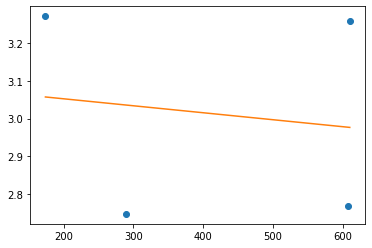

In [23]:
#3f
import matplotlib.pyplot as plt
import numpy as np
x = np.array([174, 289, 607, 610])
y = np.array(np.median(timings,axis=0))

#create basic scatterplot
plt.plot(x, y, 'o')

#obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot 
plt.plot(x, m*x+b)